## Advertising Agency Churn

A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients.

Contents
- Load Environment Libraries
- Load Spark
- Load Data & Constants
- Feature Exploration
- Machine Learning
    - Load Libraries
    - Feature Engineering
    - Machine Learning Model Selection
        - Build Model & parameter grid
            - Logistic Regression
            - Random Forest
        - Evaluation Matrix
        - Hyperparameters Optimization
        - Model Selection

Load Environment Libraries

In [1]:
import yaml
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load Spark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Classification").getOrCreate()

In [3]:
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from pyspark.sql.types import DoubleType, FloatType

Load Data & Constants

In [4]:
# load config file

with open('..\\config\\config.yaml', 'r', encoding='utf-8') as yml:
    config = yaml.load(yml, Loader=yaml.SafeLoader)
    
df = spark.read.csv(config['paths']['DATA_DIR']+config['paths']['TRAINING_DATA'], inferSchema = True, header = True)

# constants
path_FIGURE_DIR = config['paths']['FIGURE_DIR']
path_MODEL_DIR = config['paths']['MODEL_DIR']
file_MODEL_PARAMS = config['paths']['MODEL_PARAMS']
lr_MAXITER = config['ml_model_optimizer']['logistic_regression']['MAXITER']
lr_REGUPARAM = config['ml_model_optimizer']['logistic_regression']['REGUPARAM']
lr_ALPHA = config['ml_model_optimizer']['logistic_regression']['ALPHA']
rf_MAXDEPTH = config['ml_model_optimizer']['random_forest']['MAXDEPTH']
rf_NUMTREES = config['ml_model_optimizer']['random_forest']['NUMTREES']
rf_MAXBINS = config['ml_model_optimizer']['random_forest']['MAXBINS']
rf_MININSTANCESPERNODE = config['ml_model_optimizer']['random_forest']['MININSTANCESPERNODE']

num_params_lr = len(lr_MAXITER)*len(lr_REGUPARAM)*len(lr_ALPHA)
num_params_rf = len(rf_MAXDEPTH)*len(rf_NUMTREES)*len(rf_MAXBINS)*len(rf_MININSTANCESPERNODE)

Feature Exploration

In [5]:
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [6]:
df.show(3)

+----------------+---+--------------+---------------+-----+---------+--------------------+--------------------+-----+
|           Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|            Location|             Company|Churn|
+----------------+---+--------------+---------------+-----+---------+--------------------+--------------------+-----+
|Cameron Williams| 42|       11066.8|              0| 7.22|        8|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller| 41|      11916.22|              0|  6.5|       11|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano| 38|      12884.75|              0| 6.67|       12|1331 Keith Court ...|Miller, Johnson a...|    1|
+----------------+---+--------------+---------------+-----+---------+--------------------+--------------------+-----+
only showing top 3 rows



In [7]:
for row in df.head(3):
    print (row,'\n')

Row(Names='Cameron Williams', Age=42, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8, Location='10265 Elizabeth Mission Barkerburgh, AK 89518', Company='Harvey LLC', Churn=1) 

Row(Names='Kevin Mueller', Age=41, Total_Purchase=11916.22, Account_Manager=0, Years=6.5, Num_Sites=11, Location='6157 Frank Gardens Suite 019 Carloshaven, RI 17756', Company='Wilson PLC', Churn=1) 

Row(Names='Eric Lozano', Age=38, Total_Purchase=12884.75, Account_Manager=0, Years=6.67, Num_Sites=12, Location='1331 Keith Court Alyssahaven, DE 90114', Company='Miller, Johnson and Wallace', Churn=1) 



In [8]:
print (df.columns)

['Names', 'Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Location', 'Company', 'Churn']


Features of interest: 'Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites'

Feature to classify:  'Churn'

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



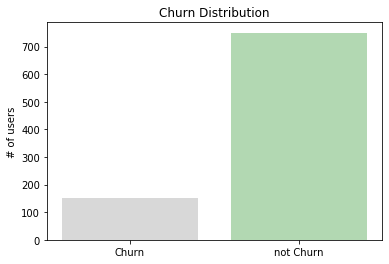

In [9]:
# Churn
df.groupBy('Churn').count().show()
# since data is imbalanced, we will consider AUC to evaluate our model

num_churn = df.groupBy('Churn').count().collect()
natural_default_rate = num_churn[0][1]/(num_churn[0][1]+num_churn[1][1])

# Churn distribution
objects = ('Churn', 'not Churn')
y_pos = np.arange(len(objects))
performance = [df.groupBy('Churn').count().collect()[0][1], df.groupBy('Churn').count().collect()[1][1]]

plt.bar(y_pos, performance, align='center', alpha=0.3, color = ['grey','g'])
plt.xticks(y_pos, objects)
plt.ylabel('# of users')
plt.title('Churn Distribution')
plt.savefig(path_FIGURE_DIR+'Churn Distribution')
plt.show()

root
 |-- Age: integer (nullable = true)



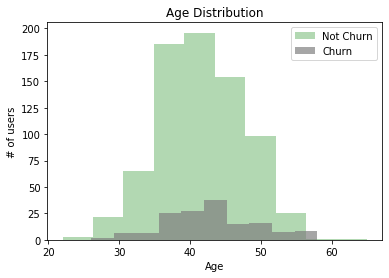

In [10]:
# Age
df.select('Age').printSchema()
a = df.filter(df.Churn == 1).select('Age').collect()
b = df.filter(df.Churn == 0).select('Age').collect()
a = [value[0] for value in a]
b = [value[0] for value in b]
plt.title('Age Distribution')
plt.hist(b, label = 'Not Churn', color = 'green', alpha = 0.3)
plt.hist(a, label = 'Churn', color = 'grey', alpha = 0.7)
plt.xlabel('Age')
plt.ylabel('# of users')
plt.legend()
plt.savefig(path_FIGURE_DIR+'Age Distribution')
plt.show()
# Feature Engineering: Age - normalization

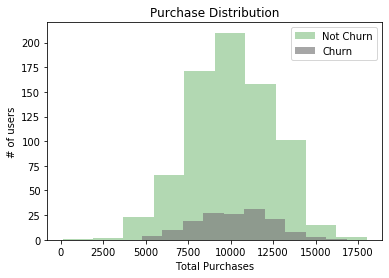

In [11]:
# Total_Purchase
a = df.filter(df.Churn == 1).select('Total_Purchase').collect()
b = df.filter(df.Churn == 0).select('Total_Purchase').collect()
a = [value[0] for value in a]
b = [value[0] for value in b]
plt.title('Purchase Distribution')
plt.hist(b, label = 'Not Churn', color = 'green', alpha = 0.3)
plt.hist(a, label = 'Churn', color = 'grey', alpha = 0.7)
plt.xlabel('Total Purchases')
plt.ylabel('# of users')
plt.legend()
plt.savefig(path_FIGURE_DIR+'Purchase Distribution')
plt.show()
# Feature Engineering: Total_Pruchase - normalization

root
 |-- Account_Manager: integer (nullable = true)

+---------------+
|Account_Manager|
+---------------+
|              1|
|              0|
+---------------+

+---------------+-----+
|Account_Manager|count|
+---------------+-----+
|              1|  433|
|              0|  467|
+---------------+-----+

Churn and Account Manager: 84 
Churn and No Account Manager: 66 
No Churn and Account Manager: 349 
No Churn and No Account Manager: 401


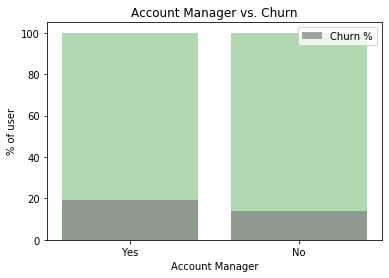

In [12]:
# Account_Manager
acc_mngr_Vect = df.select('Account_Manager')
acc_mngr_Vect.printSchema()
acc_mngr_Vect.distinct().show()
# number of classes : 2
acc_mngr_Vect.groupBy('Account_Manager').count().show()
# Feature Engineering: Not required

# Account_Manger Distribution
num_churn_acc = df.filter((df.Churn == 1) & (df.Account_Manager == 1)).count()
num_churn_no_acc = df.filter((df.Churn == 1) & (df.Account_Manager == 0)).count()
num_no_churn_acc = df.filter((df.Churn == 0) & (df.Account_Manager == 1)).count()
num_no_churn_no_acc = df.filter((df.Churn == 0) & (df.Account_Manager == 0)).count()

print ("Churn and Account Manager:",num_churn_acc,
       "\nChurn and No Account Manager:",num_churn_no_acc,
       "\nNo Churn and Account Manager:",num_no_churn_acc,
       "\nNo Churn and No Account Manager:",num_no_churn_no_acc,)

objects = ('Yes', 'No')
y_pos = np.arange(len(objects))
performance_Churn = [num_churn_acc/(num_churn_acc+num_no_churn_acc)*100,
					num_churn_no_acc/(num_churn_no_acc+num_no_churn_no_acc)*100]
performance_not_Churn = [100,100] 

plt.bar(y_pos, performance_not_Churn, align='center', alpha=0.3, color = 'g')
plt.bar(y_pos, performance_Churn, align='center', alpha=0.7, color = 'grey', label = 'Churn %')
plt.xticks(y_pos, objects)
plt.ylabel('% of user')
plt.xlabel('Account Manager')
plt.legend()
plt.title('Account Manager vs. Churn')
plt.savefig(path_FIGURE_DIR+'Account Manager_vs_Churn')

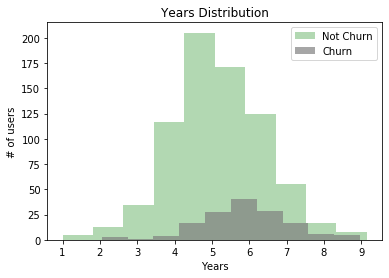

In [13]:
# Years
a = df.filter(df.Churn == 1).select('Years').collect()
b = df.filter(df.Churn == 0).select('Years').collect()
a = [value[0] for value in a]
b = [value[0] for value in b]
plt.title('Years Distribution')
plt.hist(b, label = 'Not Churn', color = 'green', alpha = 0.3)
plt.hist(a, label = 'Churn', color = 'grey', alpha = 0.7)
plt.xlabel('Years')
plt.ylabel('# of users')
plt.legend()
plt.savefig(path_FIGURE_DIR+'Years Distribution')
plt.show()
# Feature Engineering: Years - normalization

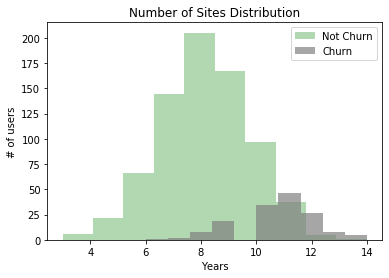

In [14]:
# Num_Sites
a = df.filter(df.Churn == 1).select('Num_Sites').collect()
b = df.filter(df.Churn == 0).select('Num_Sites').collect()
a = [value[0] for value in a]
b = [value[0] for value in b]
plt.title('Number of Sites Distribution')
plt.hist(b, label = 'Not Churn', color = 'green', alpha = 0.3)
plt.hist(a, label = 'Churn', color = 'grey', alpha = 0.7)
plt.xlabel('Years')
plt.ylabel('# of users')
plt.legend()
plt.savefig(path_FIGURE_DIR+'Number of Sites Distribution')
plt.show()
# Feature Engineering: Num_Sites - normalization

Machine Learning
- Load Libraries
- Feature Engineering
- Machine Learning Model Selection

Load Libraries

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [16]:
# Correlation Matrix

# Location Indexer
indexer_location = StringIndexer(inputCol="Location", outputCol="LocationIndex")

# Company Indexer
indexer_Co = StringIndexer(inputCol="Company", outputCol="CompanyIndex")

# Assembler: to generate Scale Vector
assembler_corr = VectorAssembler(
    inputCols=['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites','LocationIndex','CompanyIndex', 'Churn' ],
    outputCol="features_Corr")

# Feature Engineering Pipeline
pipeline_corr = Pipeline(stages = [indexer_location, indexer_Co, assembler_corr])


pipepline_corr_2 = pipeline_corr.fit(df)
data_complete_corr = pipepline_corr_2.transform(df)
data_corr = data_complete_corr.select('features_Corr')

r1 = Correlation.corr(data_corr, "features_Corr").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        , -0.0372081 , -0.01474877,  0.00562503, -0.00607048,
               0.01499416, -0.03115925,  0.08592554],
             [-0.0372081 ,  1.        ,  0.0158556 , -0.00562317, -0.00339   ,
              -0.02192963,  0.01961602,  0.02403089],
             [-0.01474877,  0.0158556 ,  1.        ,  0.02292988,  0.03340051,
              -0.00822135, -0.01603922,  0.07061077],
             [ 0.00562503, -0.00562317,  0.02292988,  1.        ,  0.05164166,
               0.0280777 , -0.04509425,  0.21432858],
             [-0.00607048, -0.00339   ,  0.03340051,  0.05164166,  1.        ,
               0.03170065,  0.02953191,  0.52539808],
             [ 0.01499416, -0.02192963, -0.00822135,  0.0280777 ,  0.03170065,
               1.        , -0.01176351, -0.03351997],
             [-0.03115925,  0.01961602, -0.01603922, -0.04509425,  0.02953191,
              -0.01176351,  1.        ,  0.03451506],
             [ 0.08592554,  0.02403089,  

Feature Engineering

In [17]:
list_features = ['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites']

In [18]:
# Feature Engineering
# Features: 'Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites'


# Assembler: to generate Scale Vector
assembler = VectorAssembler(
    inputCols=list_features,
    outputCol="featuresToScale")

# Feature Standardizer: Age, Total_Pruchase, Years, Num_Sites
scaler = StandardScaler(inputCol="featuresToScale", outputCol="features",withStd=True)

# Feature Engineering Pipeline
pipeline = Pipeline(stages = [assembler, scaler])

In [19]:
feature_engineering_pipepline = pipeline.fit(df)
feature_engineered_data = feature_engineering_pipepline.transform(df)
data = feature_engineered_data.select('features','Churn', 'Account_Manager')

Machine Learning Model Selection
- Build Model & parameter grid
    - Logistic Regression
    - Random Forest
- Evaluation Matrix
- Hyperparameters Optimization
- Model Selection

Build Model & parameter grid

In [20]:
lr = LogisticRegression(labelCol = 'Churn')
grid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, lr_REGUPARAM)\
            .addGrid(lr.maxIter, lr_MAXITER)\
            .addGrid(lr.elasticNetParam, lr_ALPHA)\
            .build()


rf = RandomForestClassifier(labelCol = 'Churn')
grid_rf = ParamGridBuilder()\
            .addGrid(rf.maxDepth, rf_MAXDEPTH)\
            .addGrid(rf.maxBins, rf_MAXBINS)\
            .addGrid(rf.numTrees, rf_NUMTREES)\
            .addGrid(rf.minInstancesPerNode, rf_MININSTANCESPERNODE)\
            .build()

Evaluation Matrix

In [21]:
# since distribution of Churn is not balance, we will use AUC matrix to make the predictions
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='Churn')

Hyperparameters Optimization

In [22]:
# build cross validator
cv_lr = CrossValidator(estimator = lr, estimatorParamMaps = grid_lr, evaluator = evaluator, numFolds = 3)
cv_rf = CrossValidator(estimator = rf, estimatorParamMaps = grid_rf, evaluator = evaluator, numFolds = 3)

In [23]:
# fit model: Logistic Regression
cv_model_lr = cv_lr.fit(data)

In [24]:
#fit model: Random Forest
cv_model_rf = cv_rf.fit(data)

In [25]:
best_model_lr = cv_model_lr.bestModel
best_model_rf = cv_model_rf.bestModel

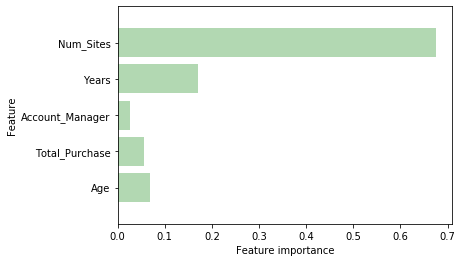

In [26]:
# Feature Importance
n_features = 5
plt.barh(range(n_features), best_model_rf.featureImportances, align='center', color = 'green', alpha = 0.3)
plt.yticks(np.arange(n_features), list_features)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.savefig(path_FIGURE_DIR+'Feature Importance')

In [27]:
auc_vec_lr = cv_model_lr.avgMetrics
auc_vec_rf = cv_model_rf.avgMetrics

In [28]:
# Result Visual: Logistic Regression
print ('\nLogistic Regression Results')
dict_log_reg_results = {'AUC':[]}
for param_idx in range(num_params_lr):
    list_param_value = list(grid_lr[param_idx].keys())
    for param_value in list_param_value:
        if param_value.name not in dict_log_reg_results:
            dict_log_reg_results[param_value.name] = []
        dict_log_reg_results[param_value.name].append(grid_lr[param_idx][param_value])
    dict_log_reg_results['AUC'].append(round(auc_vec_lr[param_idx],2))
pd.DataFrame(dict_log_reg_results)


Logistic Regression Results


,AUC,regParam,maxIter,elasticNetParam
0,0.90,0.0,100,0.00
1,0.90,0.0,100,0.01
2,0.90,0.0,100,1.00
3,0.90,1.0,100,0.00
4,0.90,1.0,100,0.01
5,0.50,1.0,100,1.00
6,0.90,10.0,100,0.00
7,0.88,10.0,100,0.01
8,0.50,10.0,100,1.00


In [29]:
# Result Visual: Random Forest
print ('\nRandom Forest Results')
dict_random_forest_results = {'AUC':[]}
for param_idx in range(num_params_rf):
    list_param_value = list(grid_rf[param_idx].keys())
    for param_value in list_param_value:
        if param_value.name not in dict_random_forest_results:
            dict_random_forest_results[param_value.name] = []
        dict_random_forest_results[param_value.name].append(grid_rf[param_idx][param_value])
    dict_random_forest_results['AUC'].append(round(auc_vec_rf[param_idx],2))
pd.DataFrame(dict_random_forest_results)


Random Forest Results


,AUC,maxDepth,maxBins,numTrees,minInstancesPerNode
0,0.88,5,30,10,1
1,0.88,5,30,10,5
2,0.89,5,30,10,10
3,0.88,5,30,20,1
4,0.89,5,30,20,5
5,0.89,5,30,20,10
6,0.88,5,30,30,1
7,0.88,5,30,30,5
8,0.88,5,30,30,10
9,0.88,5,32,10,1


Model Selection

In [30]:
def confustion_matrix(input_predictions_labels):
    predictions_labels_modified = input_predictions_labels\
                                .withColumn('TP',F.when(((F.col('prediction') == 1) & (F.col('label') == 1)), 1).otherwise(0))\
                                .withColumn('FP',F.when(((F.col('prediction') == 1) & (F.col('label') == 0)), 1).otherwise(0))\
                                .withColumn('FN',F.when(((F.col('prediction') == 0) & (F.col('label') == 1)), 1).otherwise(0))\
                                .withColumn('TN',F.when(((F.col('prediction') == 0) & (F.col('label') == 0)), 1).otherwise(0))

    true_pos = predictions_labels_modified.filter(F.col('TP') == 1).count()
    false_pos = predictions_labels_modified.filter(F.col('FP') == 1).count()
    false_neg = predictions_labels_modified.filter(F.col('FN') == 1).count()
    true_neg = predictions_labels_modified.filter(F.col('TN') == 1).count()

    return true_pos, false_pos, false_neg, true_neg

In [31]:
def training_summary(ls_threshold, transformed_data):
    
    split_udf = F.udf(lambda value: float(value[1]), DoubleType())
    transformed_data = transformed_data.withColumn('probability_1', split_udf(F.col('probability')))
    transformed_data = transformed_data.withColumn("label", F.col("Churn").cast(DoubleType()))
    
    list_accuracy = []
    list_precision = []
    list_recall = []
    list_F1 = []
    list_TPR = []
    list_FPR = []
    list_TNR = []
        
    for threshold in ls_threshold:
        
        transformed_data = transformed_data\
                            .withColumn('prediction', F.when(F.col('probability_1') > threshold, 1.0 ).otherwise(0.0))
        
        true_pos, false_pos, false_neg, true_neg = confustion_matrix(
                                                input_predictions_labels = transformed_data.select('prediction', 'label'))
        
        acc = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)
        if (true_pos + false_pos) != 0:
            prec = true_pos / (true_pos + false_pos)
        else:
            prec = 1
        recall = true_pos / (true_pos + false_neg)
        if prec + recall != 0:
            f1_score = 2*prec*recall/(prec + recall)
        else:
            f1_score = 0
        tpr = true_pos / (true_pos + false_neg)
        tnr = true_neg / (true_neg + false_pos)
        fpr = false_pos / (false_pos + true_neg)
        
        list_accuracy.append(acc)
        list_precision.append(prec)
        list_recall.append(recall)
        list_F1.append(f1_score)
        list_TPR.append(tpr)
        list_FPR.append(fpr)
        list_TNR.append(tnr)
        
    return list_accuracy, list_precision, list_recall, list_F1, list_TPR, list_TNR, list_FPR

In [32]:
def gain_lift(transformed_data, ndr, model_name):

    transformed_data = transformed_data.orderBy('probability')
    
    data_size = transformed_data.count()
    total_churn = int(ndr*data_size)
    
    gain_lift_matrix = {
        'decile': list(np.arange(10,110,10)),
        'LabeledPerDecile': [],
        'CummLabeledPerDecile': [],
        'ChurnPerCentPerDecile': [],
        model_name+'_LabeledPerDecile': [],
        model_name+'_CummLabeledPerDecile': [],
        model_name+'_ChurnPerCentPerDecile': [],
        model_name+'_CummChurnPerCentPerDecile': [],
        'RandomSelection_Gain': [],
        'RandomSelection_Lift': [],
        model_name+'_Gain': [],
        model_name+'_Lift': []
    }
    
    for decile in gain_lift_matrix['decile']:
      
        gain_lift_matrix['LabeledPerDecile'].append(ndr*data_size/10)
        gain_lift_matrix['CummLabeledPerDecile'].append(sum(gain_lift_matrix['LabeledPerDecile']))
        gain_lift_matrix['ChurnPerCentPerDecile'].append(round(ndr*100,2))
        
        gain_lift_matrix[model_name+'_CummLabeledPerDecile'].append(
            transformed_data.limit(int(decile*data_size/100)).filter(F.col('Churn') == 1).count()
        )
        
        if decile == 10:
            gain_lift_matrix[model_name+'_LabeledPerDecile'].append(
                gain_lift_matrix[model_name+'_CummLabeledPerDecile'][-1])
        else:
            gain_lift_matrix[model_name+'_LabeledPerDecile'].append(
                gain_lift_matrix[model_name+'_CummLabeledPerDecile'][-1] - \
                gain_lift_matrix[model_name+'_CummLabeledPerDecile'][-2]
            )
                
        gain_lift_matrix[model_name+'_ChurnPerCentPerDecile'].append(
            round(gain_lift_matrix[model_name+'_LabeledPerDecile'][-1]/(data_size/10)*100,2)
        )
        
        gain_lift_matrix[model_name+'_CummChurnPerCentPerDecile'].append(
            sum(gain_lift_matrix[model_name+'_ChurnPerCentPerDecile'])
        )
                
        gain_lift_matrix['RandomSelection_Gain'].append( round(gain_lift_matrix['CummLabeledPerDecile'][-1]*100 \
                                                        / (natural_default_rate*data_size), 2))
        
        gain_lift_matrix['RandomSelection_Lift'].append(round(gain_lift_matrix['RandomSelection_Gain'][-1]/decile,2))
        
        
        gain_lift_matrix[model_name+'_Gain'].append( round(gain_lift_matrix[model_name+'_CummLabeledPerDecile'][-1]*100 \
                                                    / (natural_default_rate*data_size), 2))
        
        gain_lift_matrix[model_name+'_Lift'].append(round(gain_lift_matrix[model_name+'_Gain'][-1] / decile, 2))
                
        
        
    return gain_lift_matrix

In [33]:
transformed_data_lr = best_model_lr.transform(data)

In [34]:
transformed_data_rf = best_model_rf.transform(data)

In [35]:
# AUC
auc_lr = evaluator.evaluate(transformed_data_lr)
auc_rf = evaluator.evaluate(transformed_data_rf)

In [36]:
# get threshold values
trainingSummary_lr = best_model_lr.summary
list_threshold = list(np.arange(0,0.51,0.05))

In [37]:
# RoC, Precision & Recall: Logistic Regression
list_accuracy_lr, list_precision_lr, list_recall_lr, list_F1_lr, list_TPR_lr, list_TNR_lr, list_FPR_lr\
= training_summary(ls_threshold = list_threshold, transformed_data = transformed_data_lr)

In [38]:
# RoC, Precision & Recall: Random Forest
list_accuracy_rf, list_precision_rf, list_recall_rf, list_F1_rf, list_TPR_rf, list_TNR_rf, list_FPR_rf\
= training_summary(ls_threshold = list_threshold, transformed_data = transformed_data_rf)

In [39]:
# gain-lift analysis: Logistic Regression
gain_lift_matrix_lr = gain_lift(transformed_data = transformed_data_lr, model_name = 'LogReg', ndr = natural_default_rate)

In [40]:
# gain-lift analysis: Random Forest
gain_lift_matrix_rf = gain_lift(transformed_data = transformed_data_rf, model_name = 'Rand_Forest', ndr = natural_default_rate)

In [41]:
gain_lift_matrix = {}
gain_lift_matrix.update(gain_lift_matrix_rf)
gain_lift_matrix.update(gain_lift_matrix_lr)

pd.DataFrame(gain_lift_matrix, columns = ['decile', \
                        'Rand_Forest_CummChurnPerCentPerDecile', 'LogReg_CummChurnPerCentPerDecile',
                        'RandomSelection_Gain', 'Rand_Forest_Gain', 'LogReg_Gain', \
                        'RandomSelection_Lift', 'Rand_Forest_Lift', 'LogReg_Lift'])

,decile,Rand_Forest_CummChurnPerCentPerDecile,LogReg_CummChurnPerCentPerDecile,RandomSelection_Gain,Rand_Forest_Gain,LogReg_Gain,RandomSelection_Lift,Rand_Forest_Lift,LogReg_Lift
0,10,81.11,77.78,10.0,48.67,46.67,1.0,4.87,4.67
1,20,130.00,122.22,20.0,78.00,73.33,1.0,3.90,3.67
2,30,152.22,142.22,30.0,91.33,85.33,1.0,3.04,2.84
3,40,157.78,151.11,40.0,94.67,90.67,1.0,2.37,2.27
4,50,164.45,158.89,50.0,98.67,95.33,1.0,1.97,1.91
5,60,164.45,161.11,60.0,98.67,96.67,1.0,1.64,1.61
6,70,164.45,162.22,70.0,98.67,97.33,1.0,1.41,1.39
7,80,164.45,164.44,80.0,98.67,98.67,1.0,1.23,1.23
8,90,166.67,165.55,90.0,100.00,99.33,1.0,1.11,1.10
9,100,166.67,166.66,100.0,100.00,100.00,1.0,1.00,1.00


Model Evaluation

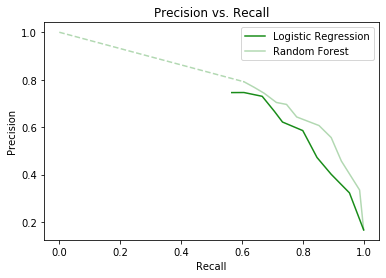

In [42]:
# Precision vs Recall
plt.title('Precision vs. Recall')
plt.plot(list_recall_lr, list_precision_lr, label = 'Logistic Regression', color = 'green', alpha = 0.9)
plt.plot(list_recall_rf, list_precision_rf, label = 'Random Forest', color = 'green', alpha = 0.3)
plt.plot([0,min(list_recall_rf)], [1, max(list_precision_rf)], color = 'green', alpha = 0.3, linestyle = '--')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig(path_FIGURE_DIR+'Precision_Recall')
plt.show()

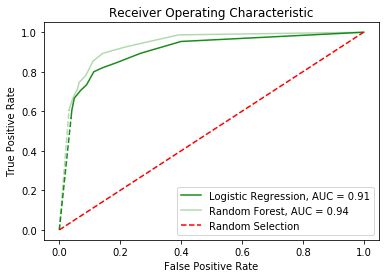

In [43]:
# ROC and AUC
plt.title('Receiver Operating Characteristic')
plt.plot(list_FPR_lr, list_TPR_lr, label = 'Logistic Regression, AUC = '+str(round(auc_lr,2)), color = 'green', alpha = 0.9)
plt.plot([0,min(list_FPR_lr)], [0,min(list_TPR_lr)], color = 'green', alpha = 0.9, linestyle = '--')
plt.plot([max(list_FPR_lr),1], [max(list_TPR_lr),1], color = 'green', alpha = 0.9, linestyle = '--')
plt.plot(list_FPR_rf, list_TPR_rf, label = 'Random Forest, AUC = '+str(round(auc_rf,2)), color = 'green', alpha = 0.3)
plt.plot([0,min(list_FPR_rf)], [0,min(list_TPR_rf)], color = 'green', alpha = 0.3, linestyle = '--')
plt.plot([max(list_FPR_rf),1], [max(list_TPR_rf),1], color = 'green', alpha = 0.3, linestyle = '--')
plt.plot([0,1], [0,1], linestyle = '--', color = 'red', label = 'Random Selection')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(path_FIGURE_DIR+'Receiver_operating_characteristic')
plt.show()

Selected Threshold: 0.15


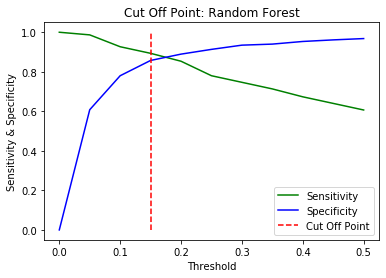

In [44]:
# Threshold Selection
idx_thresh = np.argwhere(np.diff(np.sign(np.array(list_TPR_rf) - np.array(list_TNR_rf)))).flatten()[0]
threshold_model = list_threshold[idx_thresh]
print ("Selected Threshold:", round(threshold_model,2))
plt.title('Cut Off Point: Random Forest')
plt.plot(list_threshold, list_TPR_rf, label = 'Sensitivity', color = 'green')
plt.plot(list_threshold, list_TNR_rf, label = 'Specificity', color = 'blue')
plt.plot([threshold_model, threshold_model],[0,1], color = 'red', linestyle = '--', label = 'Cut Off Point')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity & Specificity')
plt.legend()
plt.savefig(path_FIGURE_DIR+'Cut_Off_Threshold')
plt.show()

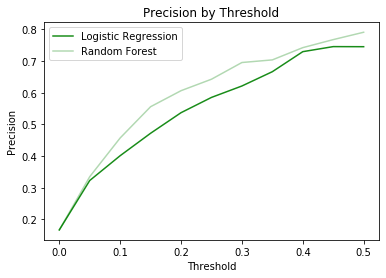

In [45]:
# Precision vs Threshold
plt.title('Precision by Threshold')
plt.plot(list_threshold, list_precision_lr, label = 'Logistic Regression', color = 'green', alpha = 0.9)
plt.plot(list_threshold, list_precision_rf, label = 'Random Forest', color = 'green', alpha = 0.3)
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.savefig(path_FIGURE_DIR+'Precision_Threshold')
plt.show()

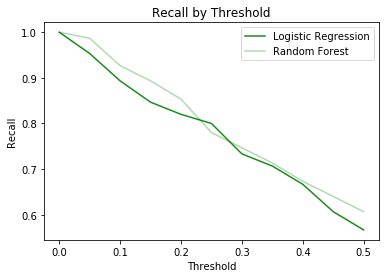

In [46]:
# Recall vs Threshold
plt.title('Recall by Threshold')
plt.plot(list_threshold, list_recall_lr, label = 'Logistic Regression', color = 'green', alpha = 0.9)
plt.plot(list_threshold, list_recall_rf, label = 'Random Forest', color = 'green', alpha = 0.3)
plt.legend()
plt.ylabel('Recall')
plt.xlabel('Threshold')
plt.savefig(path_FIGURE_DIR+'Recall_Threshold')
plt.show()

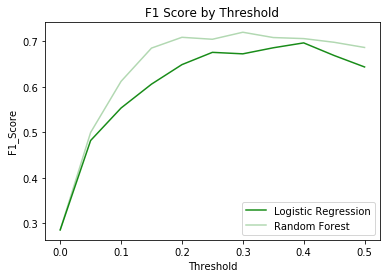

In [47]:
# F1 vs Threshold
plt.title('F1 Score by Threshold')
plt.plot(list_threshold, list_F1_lr, label = 'Logistic Regression', color = 'green', alpha = 0.9)
plt.plot(list_threshold, list_F1_rf, label = 'Random Forest', color = 'green', alpha = 0.3)
plt.legend()
plt.ylabel('F1_Score')
plt.xlabel('Threshold')
plt.savefig(path_FIGURE_DIR+'F1_Threshold')
plt.show()

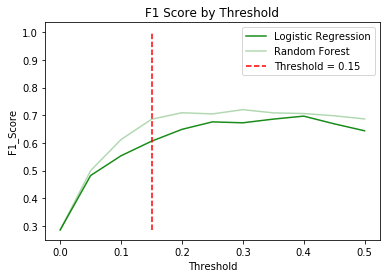

In [48]:
# F1 vs Threshold @ selected Threshold
plt.title('F1 Score by Threshold')
plt.plot(list_threshold, list_F1_lr, label = 'Logistic Regression', color = 'green', alpha = 0.9)
plt.plot(list_threshold, list_F1_rf, label = 'Random Forest', color = 'green', alpha = 0.3)
plt.plot([threshold_model, threshold_model], [min(list_F1_lr),1], color = 'red', linestyle = '--', \
                                                 label = 'Threshold = '+str(round(threshold_model,2)))
#plt.xlim([0.1, 0.6])
#plt.ylim([0.4, 0.85])
plt.legend()
plt.ylabel('F1_Score')
plt.xlabel('Threshold')
plt.savefig(path_FIGURE_DIR+'F1_Threshold_Selected')
plt.show()

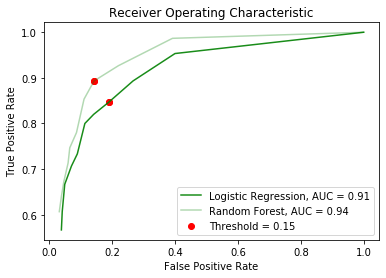

In [49]:
# ROC and AUC @ selected Threshold

tpr_lr_Thresh = list_TPR_lr[idx_thresh]
fpr_lr_Thresh = list_FPR_lr[idx_thresh]
tpr_rf_Thresh = list_TPR_rf[idx_thresh]
fpr_rf_Thresh = list_FPR_rf[idx_thresh]

plt.title('Receiver Operating Characteristic')
plt.plot(list_FPR_lr, list_TPR_lr, label = 'Logistic Regression, AUC = '+str(round(auc_lr,2)), color = 'green', alpha = 0.9)
plt.plot(list_FPR_rf, list_TPR_rf, label = 'Random Forest, AUC = '+str(round(auc_rf,2)), color = 'green', alpha = 0.3)
plt.scatter([fpr_lr_Thresh,fpr_lr_Thresh],[tpr_lr_Thresh,tpr_lr_Thresh], 
            color = 'red', label = 'Threshold = '+str(round(threshold_model,2)))
plt.scatter([fpr_rf_Thresh,fpr_rf_Thresh],[tpr_rf_Thresh,tpr_rf_Thresh], color = 'red')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(path_FIGURE_DIR+'ROC_Threshold_Selected')
plt.show()

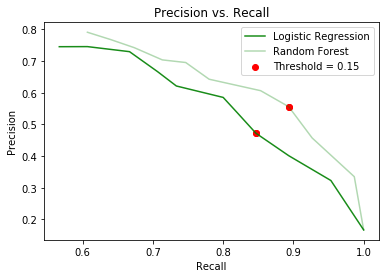

In [50]:
# Precision vs Recall @ selected Threshold

precision_lr_Thresh = list_precision_lr[idx_thresh]
recall_lr_Thresh = list_recall_lr[idx_thresh]
precision_rf_Thresh = list_precision_rf[idx_thresh]
recall_rf_Thresh = list_recall_rf[idx_thresh]

plt.title('Precision vs. Recall')
plt.plot(list_recall_lr, list_precision_lr, label = 'Logistic Regression', color = 'green', alpha = 0.9)
plt.plot(list_recall_rf, list_precision_rf, label = 'Random Forest', color = 'green', alpha = 0.3)

plt.scatter([recall_lr_Thresh,recall_lr_Thresh],[precision_lr_Thresh, precision_lr_Thresh], 
            color = 'red', label = 'Threshold = '+str(round(threshold_model,2)))
plt.scatter([recall_rf_Thresh,recall_rf_Thresh],[precision_rf_Thresh, precision_rf_Thresh], color = 'red')

plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig(path_FIGURE_DIR+'Precision_Recall_Threshold_Selected')
plt.show()

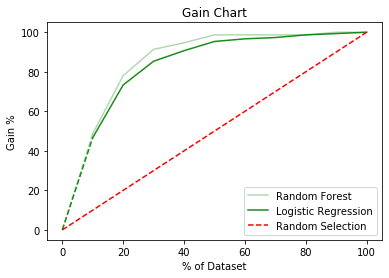

In [51]:
# Gain
plt.plot(gain_lift_matrix['decile'],gain_lift_matrix['Rand_Forest_Gain'], color = 'green', 
         alpha = 0.3, label = 'Random Forest')
plt.plot([0,10],[0,min(gain_lift_matrix['Rand_Forest_Gain'])], 
         color = 'green', alpha = 0.3, linestyle = '--')

plt.plot(gain_lift_matrix['decile'],gain_lift_matrix['LogReg_Gain'], color = 'green', 
         alpha = 0.9, label = 'Logistic Regression')
plt.plot([0,10],[0,min(gain_lift_matrix['LogReg_Gain'])], 
         color = 'green', alpha = 0.9, linestyle = '--')

plt.plot([0]+gain_lift_matrix['decile'],[0]+gain_lift_matrix['RandomSelection_Gain'], color = 'red', 
         label = 'Random Selection', linestyle = '--')

plt.title('Gain Chart')
plt.xlabel('% of Dataset')
plt.ylabel('Gain %')
plt.legend()
plt.savefig(path_FIGURE_DIR+'Gain_Chart')
plt.show()

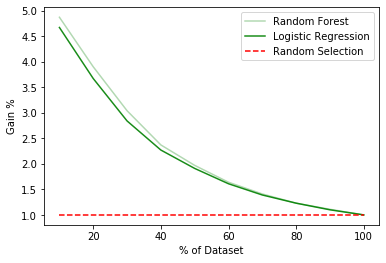

In [52]:
# Lift
plt.plot(gain_lift_matrix['decile'],gain_lift_matrix['Rand_Forest_Lift'], color = 'green', 
         alpha = 0.3, label = 'Random Forest')

plt.plot(gain_lift_matrix['decile'],gain_lift_matrix['LogReg_Lift'], color = 'green', 
         alpha = 0.9, label = 'Logistic Regression')

plt.plot(gain_lift_matrix['decile'],gain_lift_matrix['RandomSelection_Lift'], color = 'red', 
         label = 'Random Selection', linestyle = '--')


plt.xlabel('% of Dataset')
plt.ylabel('Gain %')
plt.legend()
plt.savefig(path_FIGURE_DIR+'Lift_Chart')
plt.show()

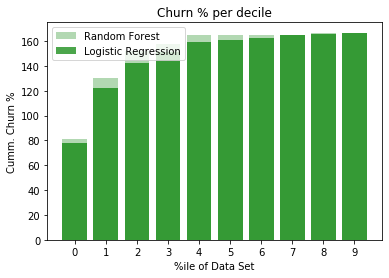

In [53]:
# Probability vs Decile
plt.title('Churn % per decile')
index = np.arange(len(gain_lift_matrix['decile']))
plt.bar(index, gain_lift_matrix['Rand_Forest_CummChurnPerCentPerDecile'], color = 'green', alpha = 0.3, label = 'Random Forest')
plt.bar(index, gain_lift_matrix['LogReg_CummChurnPerCentPerDecile'], color = 'green', alpha = 0.7, label = 'Logistic Regression')
plt.xlabel('%ile of Data Set')
plt.ylabel('Cumm. Churn %')
plt.legend()
plt.xticks(index)
plt.savefig(path_FIGURE_DIR+'Churn_PerCent_Decile')

plt.show()

In [54]:
# Evaluation Matrix
evaluation_matrix = {
    'Random Forest':{
        'Threshold': round(threshold_model,2),
        'Accuracy': round(list_accuracy_rf[idx_thresh],2),
        'Precision': round(list_precision_rf[idx_thresh],2),
        'Recall': round(list_recall_rf[idx_thresh],2),
        'F1 Score': round(list_F1_rf[idx_thresh],2),
        'AUC': round(auc_rf,2)
    },
    'Logistic Regression':{
        'Threshold': round(threshold_model,2),
        'Accuracy': round(list_accuracy_lr[idx_thresh],2),
        'Precision': round(list_precision_lr[idx_thresh],2),
        'Recall': round(list_recall_lr[idx_thresh],2),
        'F1 Score': round(list_F1_lr[idx_thresh],2),
        'AUC': round(auc_lr,2)
    }
}

pd.DataFrame(evaluation_matrix)

,Random Forest,Logistic Regression
Threshold,0.15,0.15
Accuracy,0.86,0.82
Precision,0.56,0.47
Recall,0.89,0.85
F1 Score,0.69,0.61
AUC,0.94,0.91


In [55]:
# dump model parameters
model_parameters = {
    'model_algorithm': 'Random Forest',
    'threshold': threshold_model,
    'decile': 0.5,
    'MAXDEPTH': best_model_rf.extractParamMap()[best_model_rf.maxDepth],
    'NUMTREES': best_model_rf.extractParamMap()[best_model_rf.numTrees],
    'MAXBINS': best_model_rf.extractParamMap()[best_model_rf.maxBins],
    'MININSTANCESPERNODE':best_model_rf.extractParamMap()[best_model_rf.minInstancesPerNode]
}
config.update({'Machine Learning Model Parameters':model_parameters})